In [21]:
import numpy                as np
from os                     import listdir
import matplotlib.pyplot    as plt
import matplotlib           as mpl
import matplotlib.lines     as mlines
from natsort                import natsorted
import os
import json
import CSEmodel as cse

from matplotlib             import rcParams, rc
rcParams.update({'figure.dpi': 200})
rc('font', family='serif')
rc('text', usetex=True)

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('/STER/silkem/MACE/')
import src.mace.utils as utils
import src.mace.CSE_0D.dataset as ds 

from matplotlib             import rcParams, rc
rcParams.update({'figure.dpi': 200})



def makeOutputDir(path):
    if not os.path.exists(path):
        os.mkdir(path)
    return path

specs_dict, idx_specs = utils.get_specs()



def get_time(dt, idx):
    t = np.zeros(len(dt))
    t[0] = CSEmodel.time[idx]
    for i in range(0,len(t)-1):
        t[i+1] = (dt[i]+t[i])
        
    return np.array(t)



def read_input(infile):

    # with open(infile, 'a') as file:
    #         file.write('\nName = '+name+'\n')

    with open(infile,'r') as f:
        file = f.readlines()
        lines = []
        for line in file:
            lines.append(line.split())

    inputfile = {}
    for i in range(len(lines)):
        if not len(lines[i]) == 0 and len(lines[i]) > 2:
            inputfile[lines[i][0]] = lines[i][2]
        elif not len(lines[i]) == 0 and len(lines[i]) <= 2:
            print('You forgot to give an input for '+lines[i][0])

    return inputfile

In [62]:
## Get KROME output

path = '/STER/silkem/kromeCSE/out/'
abs_krome = list()

for i in range(1,135):
    file = path+str(i)+'.out'
    n = np.loadtxt(file, usecols=(1))
    abs_krome.append(n)

abs_krome = np.array(abs_krome).T

In [75]:
## Get CSE output
path0D = '/STER/silkem/fortran_0D/'

modname = '20211015_gridC_Mdot1e-6_v17-5_T_eps_model_2022-12-24h17-06-51/'

abs_umist = list()

for i in range(2, 136):
    print(i)
    file = path0D + 'rates/'+ modname + 'krome/abs_' + str(i) + '.txt'
    n = np.loadtxt(file, usecols=(2))
    abs_umist.append(n)

abs_umist = np.array(abs_umist).T


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135


In [87]:
dens = list()

for i in range(1,134):
    # print(i)
    infile = path0D + 'input/' + modname + 'krome/input_' + str(i) + '.in'
    input = read_input(infile)
    dens.append(float(input['DN']))

dens = np.array(dens)

In [53]:
print(abs_umist.shape,abs.shape)

(468, 134) (468, 134)


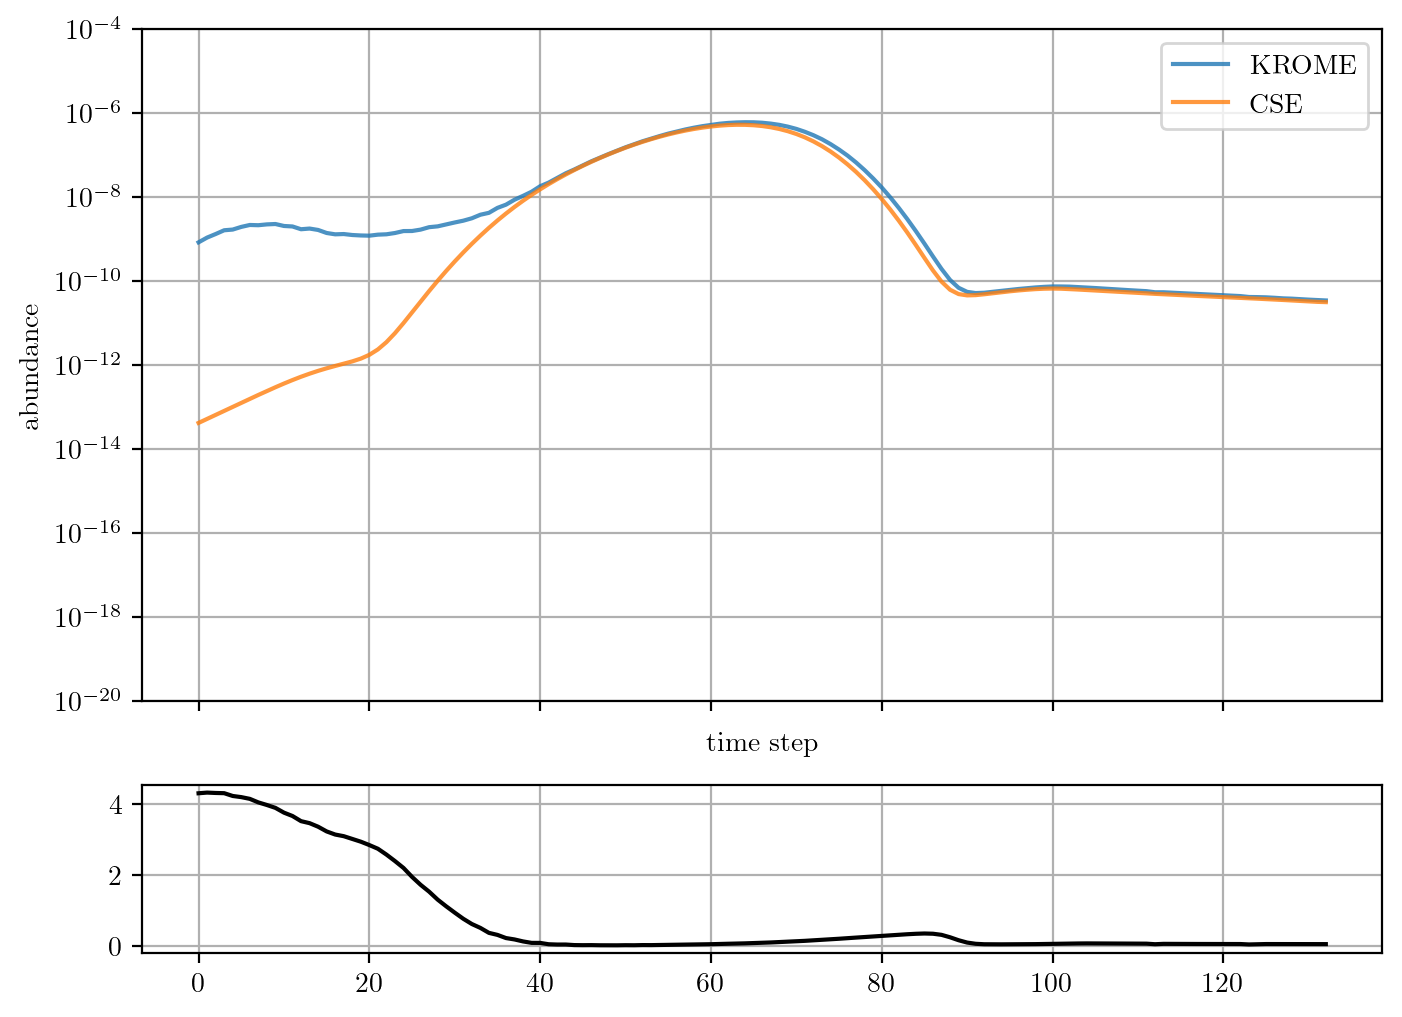

In [107]:
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [4,1]},figsize=(8, 6))
ax1 = axs[0]
ax2 = axs[1]

spec = 46
alpha = 0.8

krome = abs_krome[spec-1][:-1]/dens
umist = abs_umist[spec-1][:-1]/dens

ax1.plot(krome, label = 'KROME', alpha=alpha)
ax1.plot(umist, label = 'CSE', alpha=alpha)

ax2.plot(np.log10(krome)-np.log10(umist), label = 'KROME/CSE', c='k')

ax1.set_yscale('log')
ax1.set_ylim(1e-20, 1e-4)

ax1.set_ylabel('abundance')
ax1.set_xlabel('time step')

ax1.xaxis.set_ticklabels([])
ax1.grid(True)
ax2.grid(True)

ax1.legend()
plt.show()

In [113]:
logdiffs = list()

for i in range(0,468):
    krome = abs_krome[i][:-1]/dens
    umist = abs_umist[i][:-1]/dens

    logdiffs.append(np.log10(krome)-np.log10(umist))

logdiffs = np.array(logdiffs).T

In [144]:
logdiffs = np.nan_to_num(logdiffs)

In [145]:
avg = np.mean(logdiffs, axis= 1)

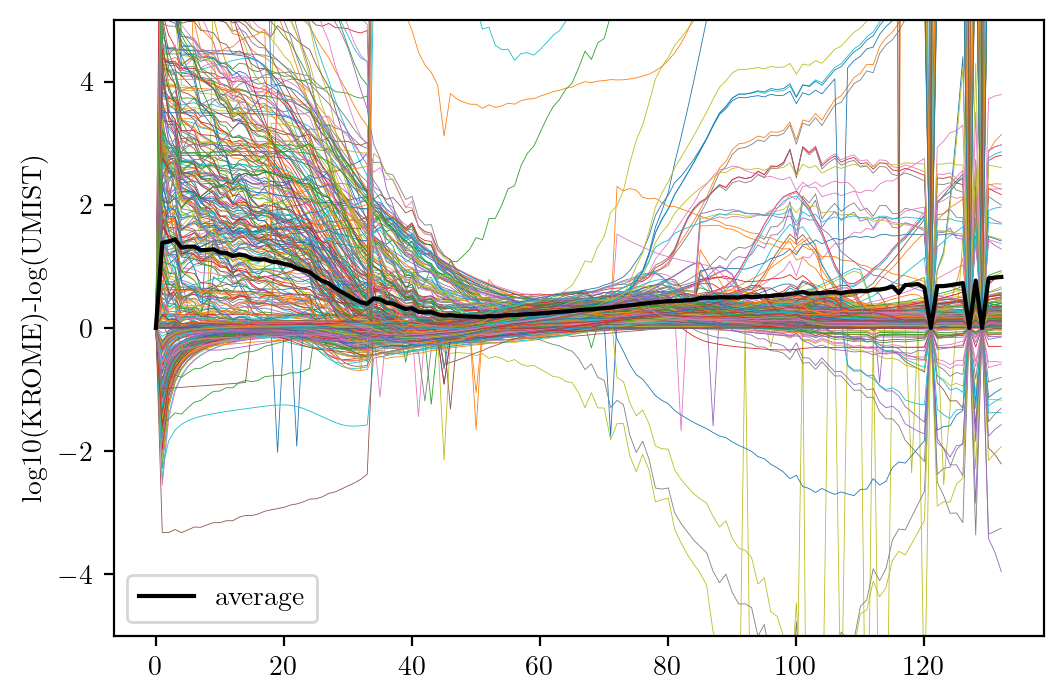

In [150]:
fig, ax1 = plt.subplots(figsize = (6,4)) 
ax1.plot(logdiffs, lw = 0.3)
ax1.plot(avg, c='k', label='average')

ax1.set_ylabel('log10(KROME)-log(UMIST)')
ax1.set_ylim(-5,5)

ax1.legend()
plt.show()